**处理流程：**使用增强后数据且目标变量变换进行特征筛选
1. 缺失值填充 — 用 KNN（基于相似样本补齐）
2. 缩尾+Yeo-Johnson
3. 特征筛选 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# 公共常量定义
TARGET_COL = 'lipid(%)'

## 加载数据处理缺失值

In [2]:
df = pd.read_excel('../data/raw/row_data_augment.xlsx')
print(f'原始数据形状: {df.shape}')
print(f'缺失值统计:')
print(df.isnull().sum()[df.isnull().sum() > 0])

原始数据形状: (50, 19)
缺失值统计:
Series([], dtype: int64)


In [3]:
# 查看缺失值的具体情况
missing_cols = ['phosphate']

print('样本缺失：')
for col in missing_cols:
    missing_idx = df[df[col].isnull()].index.tolist()
    print(f'  {col}: {len(missing_idx)} 个缺失，第 {missing_idx} 行')

样本缺失：
  phosphate: 0 个缺失，第 [] 行


In [4]:
# 用 KNN 填充缺失值（只对数值列，避免用目标列参与填充）

print('KNN 填充缺失值：')
df_filled = df.copy()

# 仅对数值列做 KNN 填充，目标列不参与以避免泄露
numeric_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()
imputer_cols = [c for c in numeric_cols if c != TARGET_COL]

missing_before = df_filled[imputer_cols].isna().sum()
imputer = KNNImputer(n_neighbors=5, weights='distance')

df_filled[imputer_cols] = imputer.fit_transform(df_filled[imputer_cols])

for col in missing_cols:
    before = missing_before.get(col, 0)
    after = df_filled[col].isna().sum()
    print(f'  {col}: 原有 {before} 个缺失，填充后剩余 {after} 个')


KNN 填充缺失值：
  phosphate: 原有 0 个缺失，填充后剩余 0 个


KNN 填充后数据形状: (50, 19)
数值列: 19 | 目标列: lipid(%)
正态性检验结果 (p<0.05 视为拒绝正态):
                           column   n        mean         std     shapiro_p   dagostino_p  shapiro_normal  \
0                              TP  50    0.436216    0.996602  1.269870e-12  9.317871e-20          reject   
1                       phosphate  50    0.168743    0.273138  1.066569e-09  6.221405e-09          reject   
2    Algal density（×10^5cells/ml)  50   20.984299   23.696922  2.100036e-09  9.560844e-06          reject   
3   Total photosynthetic pigments  50    0.700876    0.728159  1.114640e-07  5.734502e-05          reject   
4                ammonia nitrogen  50    0.375673    0.454133  2.557339e-07  7.506141e-06          reject   
5                             BOD  50    5.191273    5.094188  2.160598e-06  1.387869e-02          reject   
6                        lipid(%)  50    7.562991    5.786305  2.890716e-06  4.839038e-56          reject   
7                       Turbidity  50   11.972064   10.19

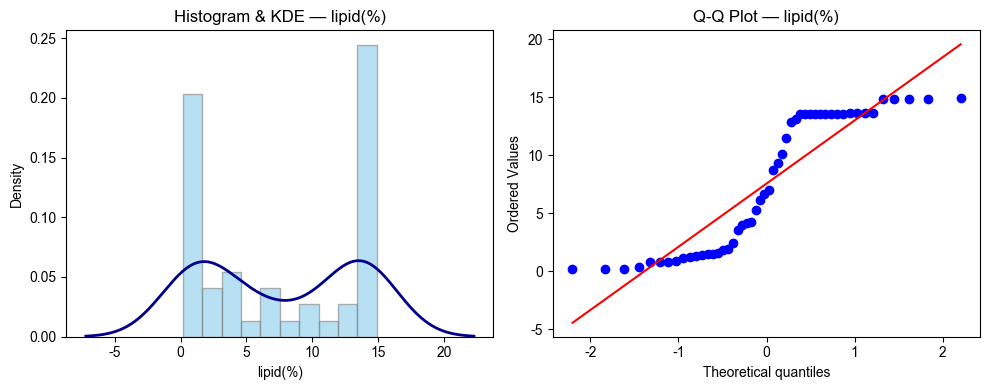

In [5]:
# KNN 填充后数据的正态性检验
from typing import Iterable

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

def infer_target_col(df, keywords: Iterable[str] = ('lipid', '脂质')) -> str:
    for col in df.columns:
        lower = str(col).lower()
        if any(key.lower() in lower for key in keywords):
            return col
    raise ValueError(f'No target column found containing any of {keywords}. Columns: {list(df.columns)}')

analysis_df = df_filled
y_col = infer_target_col(analysis_df)
num_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()

print(f'KNN 填充后数据形状: {analysis_df.shape}')
print(f'数值列: {len(num_cols)} | 目标列: {y_col}')

results = []
for col in num_cols:
    data = analysis_df[col].dropna().astype(float)
    n = len(data)
    if n < 8:  # normaltest 需要 n>=8
        continue
    shapiro_stat, shapiro_p = stats.shapiro(data)
    k2_stat, k2_p = stats.normaltest(data)
    results.append({
        'column': col,
        'n': n,
        'mean': data.mean(),
        'std': data.std(ddof=1),
        'shapiro_p': shapiro_p,
        'dagostino_p': k2_p,
        'shapiro_normal': 'fail to reject' if shapiro_p >= 0.05 else 'reject',
        'dagostino_normal': 'fail to reject' if k2_p >= 0.05 else 'reject',
    })

results_df = pd.DataFrame(results).sort_values('shapiro_p')
print('正态性检验结果 (p<0.05 视为拒绝正态):')
print(results_df.reset_index(drop=True))

# 直方图 + KDE 与 Q-Q 图，默认查看目标列，可根据需要改成其他列
column_to_plot = y_col
if column_to_plot not in num_cols:
    raise ValueError(f'Column {column_to_plot} not numeric. Choose one of: {num_cols}')

series = analysis_df[column_to_plot].dropna().astype(float)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(series, bins=10, density=True, alpha=0.6, color='skyblue', edgecolor='gray')
series.plot.kde(ax=axes[0], color='darkblue', lw=2)
axes[0].set_title(f'Histogram & KDE — {column_to_plot}')
axes[0].set_xlabel(column_to_plot)
axes[0].set_ylabel('Density')
stats.probplot(series, dist='norm', plot=axes[1])
axes[1].set_title(f'Q-Q Plot — {column_to_plot}')
plt.tight_layout()
plt.show()


In [6]:
# 保存已填充但未对数的数据（如需要）
output_path = '../data/processed/data_cleaned.xlsx'
df_filled.to_excel(output_path, index=False)
print(f'数据保存路径: {output_path}')
print(f'数据状态: {df_filled.shape}')
# 对数变换后的保存已在后续 log 单元完成

数据保存路径: ../data/processed/data_cleaned.xlsx
数据状态: (50, 19)


IQR 规则离群点数量（标准化前）：
                           column   n  outliers      lower        upper         min         max
0    Algal density（×10^5cells/ml)  50         8 -12.241321    39.418129    2.066670   84.188890
1                       phosphate  50         8  -0.244245     0.439741    0.001955    1.315000
2                             COD  50         7  -4.175798    58.281649    7.383197   70.400000
3   Total photosynthetic pigments  50         6  -0.746933     1.731555    0.035404    2.514000
4                              TP  50         4  -0.624023     1.115372    0.010000    6.503036
5                ammonia nitrogen  50         3  -0.765308     1.462180    0.000000    1.960000
6                             TOC  50         3   1.154195     8.779008    1.690000   11.310000
7                       Turbidity  50         1 -18.478352    42.087011    2.600000   46.650000
8            Specific growth rate  50         1  -0.103962     0.484380    0.025567    0.501775
9                    

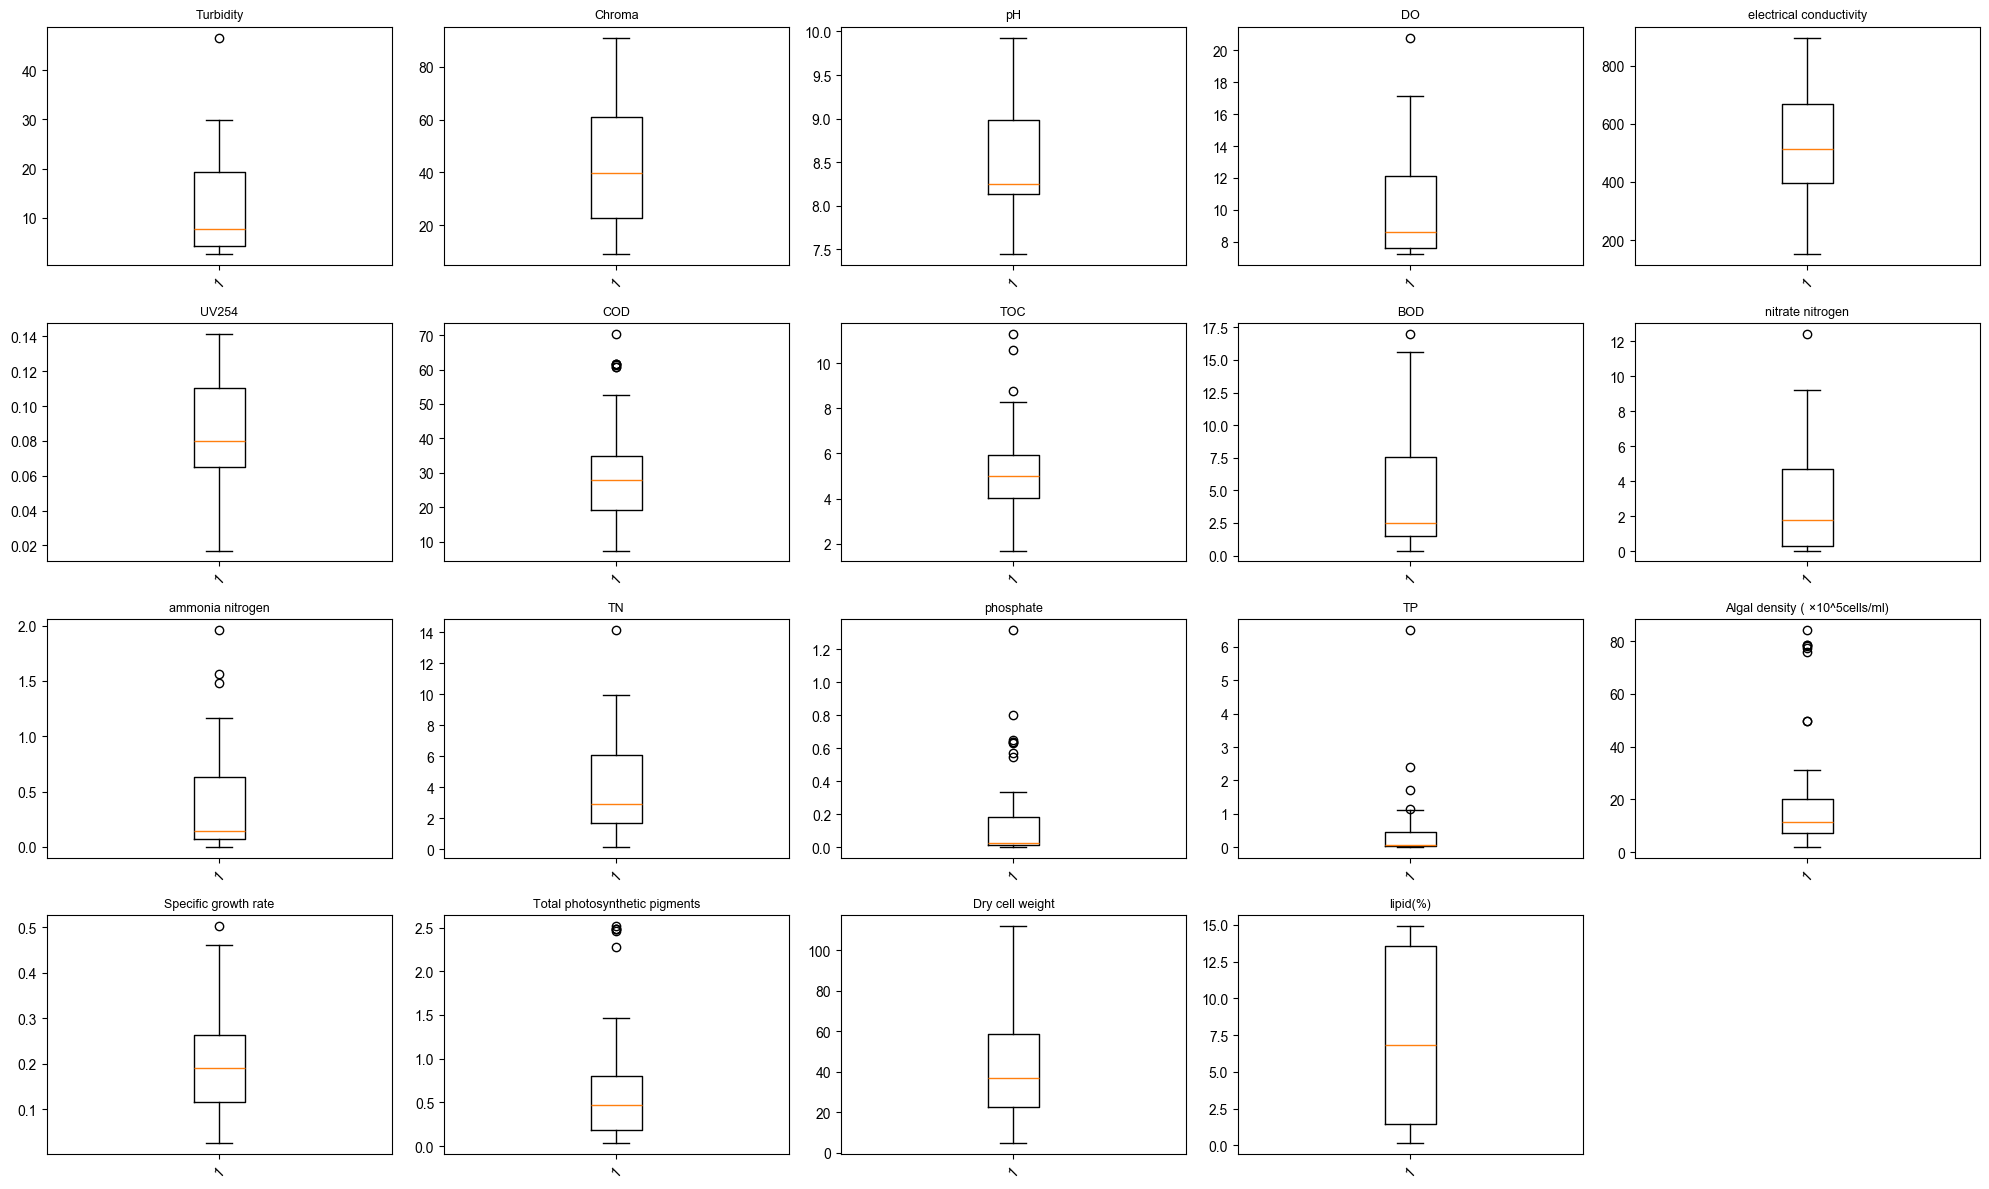

In [7]:
# KNN 填充后：箱线图查看离群值概况（标准化前）
num_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()

# IQR 规则统计离群点数量
outlier_summary = []
for col in num_cols:
    s = df_filled[col].dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask = (s < lower) | (s > upper)
    outlier_summary.append({
        'column': col,
        'n': s.shape[0],
        'outliers': int(mask.sum()),
        'lower': lower,
        'upper': upper,
        'min': s.min(),
        'max': s.max(),
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('outliers', ascending=False)
print('IQR 规则离群点数量（标准化前）：')
print(outlier_df.reset_index(drop=True))

# 箱线图展示
n_cols = 5
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()
for idx, col in enumerate(num_cols):
    axes[idx].boxplot(df_filled[col].dropna(), vert=True)
    axes[idx].set_title(col, fontsize=9)
    axes[idx].tick_params(axis='x', labelrotation=45)

# 关闭多余子图
for ax in axes[len(num_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# 对数变换：对所有数值列（含目标）做 log1p 以降低偏态
import numpy as np

numeric_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()
df_log = df_filled.copy()

# 检查是否有值 <= -1，log1p 前需保证 > -1
min_vals = df_log[numeric_cols].min()
if (min_vals <= -1).any():
    print('警告: 以下列存在值 <= -1，无法直接 log1p：', min_vals[min_vals <= -1].to_dict())

df_log[numeric_cols] = df_log[numeric_cols].apply(np.log1p)

print('log1p 后最小值：', df_log[numeric_cols].min().to_dict())


# 保存 log1p 后的数据
output_path = '../data/processed/data_cleaned_log_augment.xlsx'
df_log.to_excel(output_path, index=False)
print(f'log1p 数据保存路径: {output_path}')
print(f'数据状态: {df_log.shape}')


log1p 后最小值： {'Turbidity': 1.2809338454620642, 'Chroma': 2.302585092994046, 'pH': 2.1329823086078656, 'DO': 2.105352923464337, 'electrical conductivity': 5.0238805208462765, 'UV254': 0.0168571170664229, 'COD': 2.12622936708446, 'TOC': 0.9895411936137477, 'BOD': 0.32465938569049413, 'nitrate nitrogen': 0.029934277708300417, 'ammonia nitrogen': 0.0, 'TN': 0.15700374880966475, 'phosphate': 0.0019534812625818473, 'TP': 0.009950330853168083, 'Algal density（×10^5cells/ml)': 1.1205922823428158, 'Specific growth rate': 0.02524531250655623, 'Total photosynthetic pigments': 0.03479154998660315, 'Dry cell weight': 1.7373429993499454, 'lipid(%)': 0.15280368703966454}
log1p 数据保存路径: ../data/processed/data_cleaned_log_augment.xlsx
数据状态: (50, 19)


In [9]:
# 对离群明显的特征先做温和缩尾 (winsorize)，再用 Yeo-Johnson 标准化
from sklearn.preprocessing import PowerTransformer
from collections import OrderedDict

# 使用公共常量 TARGET_COL
y = df_log[TARGET_COL].copy()

feature_cols = df_log.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove(TARGET_COL)
X = df_log[feature_cols].copy()

# 处理可能存在的 inf 值
X = X.replace([np.inf, -np.inf], np.nan)

# 如果还有 NaN，用列中位数补全
for col in X.columns:
    if X[col].isna().any():
        X[col].fillna(X[col].median(), inplace=True)

# 基于 IQR 检测离群，离群列做 1%/99% 分位缩尾
winsor_bounds = OrderedDict()
for col in feature_cols:
    s = X[col]
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    if ((s < lower) | (s > upper)).any():
        lo, hi = s.quantile([0.01, 0.99])
        winsor_bounds[col] = (lo, hi)
        X[col] = s.clip(lower=lo, upper=hi)

print(f'缩尾处理列数: {len(winsor_bounds)}')
if winsor_bounds:
    for k, (lo, hi) in winsor_bounds.items():
        print(f'  {k}: 1%={lo:.4f}, 99%={hi:.4f}')

# Yeo-Johnson 变换 + 标准化
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_scaled = pt.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df_log.index)

# 安全检查
if X_scaled_df.isna().any().any():
    X_scaled_df = X_scaled_df.fillna(0)
    print('注意: 变换后发现 NaN，已填充为 0')

print(f'Yeo-Johnson 标准化完成，共 {len(feature_cols)} 个特征')
for col in feature_cols[:3]:
    m = X_scaled_df[col].mean()
    s = X_scaled_df[col].std(ddof=0)
    print(f'  {col}: 均值={m:.4f}, 标准差={s:.4f}')


缩尾处理列数: 7
  electrical conductivity: 1%=5.0816, 99%=6.7645
  COD: 1%=2.1357, 99%=4.2046
  TOC: 1%=1.0144, 99%=2.4817
  phosphate: 1%=0.0025, 99%=0.7170
  TP: 1%=0.0100, 99%=1.6264
  Total photosynthetic pigments: 1%=0.0416, 99%=1.2528
  Dry cell weight: 1%=1.7384, 99%=4.6873
Yeo-Johnson 标准化完成，共 18 个特征
  Turbidity: 均值=-0.0000, 标准差=1.0000
  Chroma: 均值=0.0000, 标准差=1.0000
  pH: 均值=-0.0000, 标准差=1.0000


In [10]:
# 标准化结果打包与保存
df_standardized = X_scaled_df.copy()
df_standardized[TARGET_COL] = y

output_path = '../data/processed/data_standardized_log_augment.xlsx'
df_standardized.to_excel(output_path, index=False)
print(f'标准化数据保存路径: {output_path}')
print(f'数据状态: {df_standardized.shape}')


标准化数据保存路径: ../data/processed/data_standardized_log_augment.xlsx
数据状态: (50, 19)


## 特征筛选

In [11]:
df = df_standardized.copy()
y = df[TARGET_COL].values

feature_cols = df.columns.tolist()
feature_cols.remove(TARGET_COL)

X = df[feature_cols].values

print(f'特征数量: {len(feature_cols)}')
print(f'样本数量: {len(y)}')

特征数量: 18
样本数量: 50


In [12]:
# Pearson 相关系数
# 简单直观，看特征和目标的线性相关程度

corr_scores = {}
for i, col in enumerate(feature_cols):
    if np.isclose(np.std(X[:, i]), 0):
        corr_scores[col] = 0.0
        continue
    corr = np.corrcoef(X[:, i], y)[0, 1]
    corr_scores[col] = 0.0 if np.isnan(corr) else abs(corr)

print('相关系数前 14 ：')
for feat, score in sorted(corr_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.3f}')

相关系数前 14 ：
  DO: 0.273
  pH: 0.272
  nitrate nitrogen: 0.246
  Dry cell weight: 0.172
  TOC: 0.125
  UV254: 0.111
  electrical conductivity: 0.107
  ammonia nitrogen: 0.091
  BOD: 0.089
  phosphate: 0.089
  Turbidity: 0.070
  Total photosynthetic pigments: 0.068
  Algal density（×10^5cells/ml): 0.062
  COD: 0.060


In [13]:
# 随机森林
# 捕捉非线性关系，根据特征在树分裂时的贡献打分
rf = RandomForestRegressor(n_estimators=1000, max_depth=3,min_samples_leaf=3,min_samples_split=6,max_features="sqrt", random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_scores = dict(zip(feature_cols, rf.feature_importances_))

print('随机森林前 14 ：')
for feat, score in sorted(rf_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.4f}')

随机森林前 14 ：
  TOC: 0.1314
  DO: 0.1088
  nitrate nitrogen: 0.0994
  pH: 0.0780
  TN: 0.0683
  Turbidity: 0.0669
  Total photosynthetic pigments: 0.0626
  BOD: 0.0552
  Dry cell weight: 0.0424
  UV254: 0.0395
  electrical conductivity: 0.0389
  COD: 0.0337
  Algal density（×10^5cells/ml): 0.0330
  TP: 0.0306


In [14]:
# PLS 回归 (VIP 得分)
# VIP > 1 认为是重要特征

n_samples, n_features = X.shape
n_components = min(3, n_samples - 1, n_features)

pls = PLSRegression(n_components=n_components,scale=False)
pls.fit(X, y)

def calculate_vip(pls):
    t = pls.x_scores_          # (n, h)
    w = pls.x_weights_         # (p, h)
    q = pls.y_loadings_        # (m, h)  m=targets

    p, h = w.shape

    # 每个成分解释的 y 方差贡献（常见写法）
    s = np.sum(t**2, axis=0) * np.sum(q**2, axis=0)   # (h,)
    total_s = np.sum(s)
    if np.isclose(total_s, 0):
        return np.zeros(p)

    # 归一化每个成分的权重向量
    w_norm2 = (w / np.linalg.norm(w, axis=0))**2       # (p, h)

    vip = np.sqrt(p * (w_norm2 @ s) / total_s)         # (p,)
    return vip


pls_scores = dict(zip(feature_cols, calculate_vip(pls)))

print('PLS VIP 前 14 名：')
for feat, score in sorted(pls_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.3f}')

PLS VIP 前 14 名：
  nitrate nitrogen: 1.499
  DO: 1.463
  pH: 1.455
  Dry cell weight: 1.405
  Total photosynthetic pigments: 1.250
  Algal density（×10^5cells/ml): 1.011
  Chroma: 0.949
  Specific growth rate: 0.921
  BOD: 0.915
  phosphate: 0.853
  TP: 0.850
  TOC: 0.833
  UV254: 0.705
  electrical conductivity: 0.690


In [15]:
# 递归特征消除 (RFE)
# 反复训练模型，每次剔除最不重要的特征，最后看哪些留到了最后

base_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0])
rfe = RFE(estimator=base_model, n_features_to_select=6, step=1)
rfe.fit(X, y)

max_rank = max(rfe.ranking_)
rfe_scores = {col: max_rank - rfe.ranking_[i] + 1 for i, col in enumerate(feature_cols)}

print('【RFE】最终保留的 6 个特征：')
for feat in np.array(feature_cols)[rfe.support_]:
    print(f'  {feat}')

【RFE】最终保留的 6 个特征：
  nitrate nitrogen
  TN
  Algal density（×10^5cells/ml)
  Specific growth rate
  Total photosynthetic pigments
  Dry cell weight


In [16]:
# Spearman 秩相关系数
# 衡量单调关系（不仅限于线性），对异常值更稳健

spearman_scores = {}
for i, col in enumerate(feature_cols):
    xi = X[:, i]
    if np.isclose(np.std(xi), 0):
        spearman_scores[col] = 0.0
        continue
    rho, _ = stats.spearmanr(xi, y, nan_policy='omit')
    spearman_scores[col] = 0.0 if np.isnan(rho) else abs(rho)


print('Spearman 秩相关前 14：')
for feat, score in sorted(spearman_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.3f}')

Spearman 秩相关前 14：
  pH: 0.270
  DO: 0.256
  UV254: 0.224
  nitrate nitrogen: 0.184
  Dry cell weight: 0.159
  Chroma: 0.150
  COD: 0.147
  BOD: 0.140
  TOC: 0.136
  Total photosynthetic pigments: 0.109
  electrical conductivity: 0.105
  Specific growth rate: 0.077
  Algal density（×10^5cells/ml): 0.067
  TN: 0.048


In [17]:
# 互信息 (Mutual Information)
# 捕捉任意类型的依赖关系（线性/非线性），基于信息论
const_mask = np.isclose(np.std(X, axis=0), 0)
mi_arr = mutual_info_regression(X, y, random_state=42, n_neighbors=5)
mi_arr[const_mask] = 0.0

mi_scores = dict(zip(feature_cols, mi_arr))

print('互信息 MI 前 14：')
for feat, score in sorted(mi_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.4f}')

互信息 MI 前 14：
  nitrate nitrogen: 0.3023
  TN: 0.2642
  DO: 0.2630
  Total photosynthetic pigments: 0.2124
  BOD: 0.2065
  pH: 0.1925
  COD: 0.1865
  TOC: 0.1855
  Turbidity: 0.1753
  Algal density（×10^5cells/ml): 0.1165
  Chroma: 0.1125
  electrical conductivity: 0.0908
  TP: 0.0709
  Specific growth rate: 0.0320


In [18]:
# 综合得分只看 Spearman 与 PLS (两种方法平均)

def normalize(scores):
    vals = np.array(list(scores.values()))
    vals = np.nan_to_num(vals, nan=0.0)
    if vals.max() - vals.min() > 0:
        normed = (vals - vals.min()) / (vals.max() - vals.min())
    else:
        normed = np.zeros_like(vals)
    return dict(zip(scores.keys(), normed))

scores_dict = {
    'Spearman': spearman_scores,
    'PLS': pls_scores
}

feature_cols = list(scores_dict['Spearman'].keys())

data = {'feature': feature_cols}
for name, scores in scores_dict.items():
    data[f'{name}_Raw'] = [scores[f] for f in feature_cols]
for name, scores in scores_dict.items():
    norm_scores = normalize(scores)
    data[name] = [norm_scores[f] for f in feature_cols]

summary_df = pd.DataFrame(data)
summary_df['Average'] = summary_df[list(scores_dict.keys())].mean(axis=1)
summary_df = summary_df.sort_values('Average', ascending=False)

print('【综合排名】前 10 名（Spearman + PLS）：')
print(summary_df[['feature', 'Average']].head(10).to_string(index=False))


【综合排名】前 10 名（Spearman + PLS）：
                      feature  Average
                           pH 0.978363
                           DO 0.956703
             nitrate nitrogen 0.841629
              Dry cell weight 0.747563
Total photosynthetic pigments 0.577489
                        UV254 0.520000
                       Chroma 0.504375
                          BOD 0.469794
                          TOC 0.420744
 Algal density（×10^5cells/ml) 0.380542


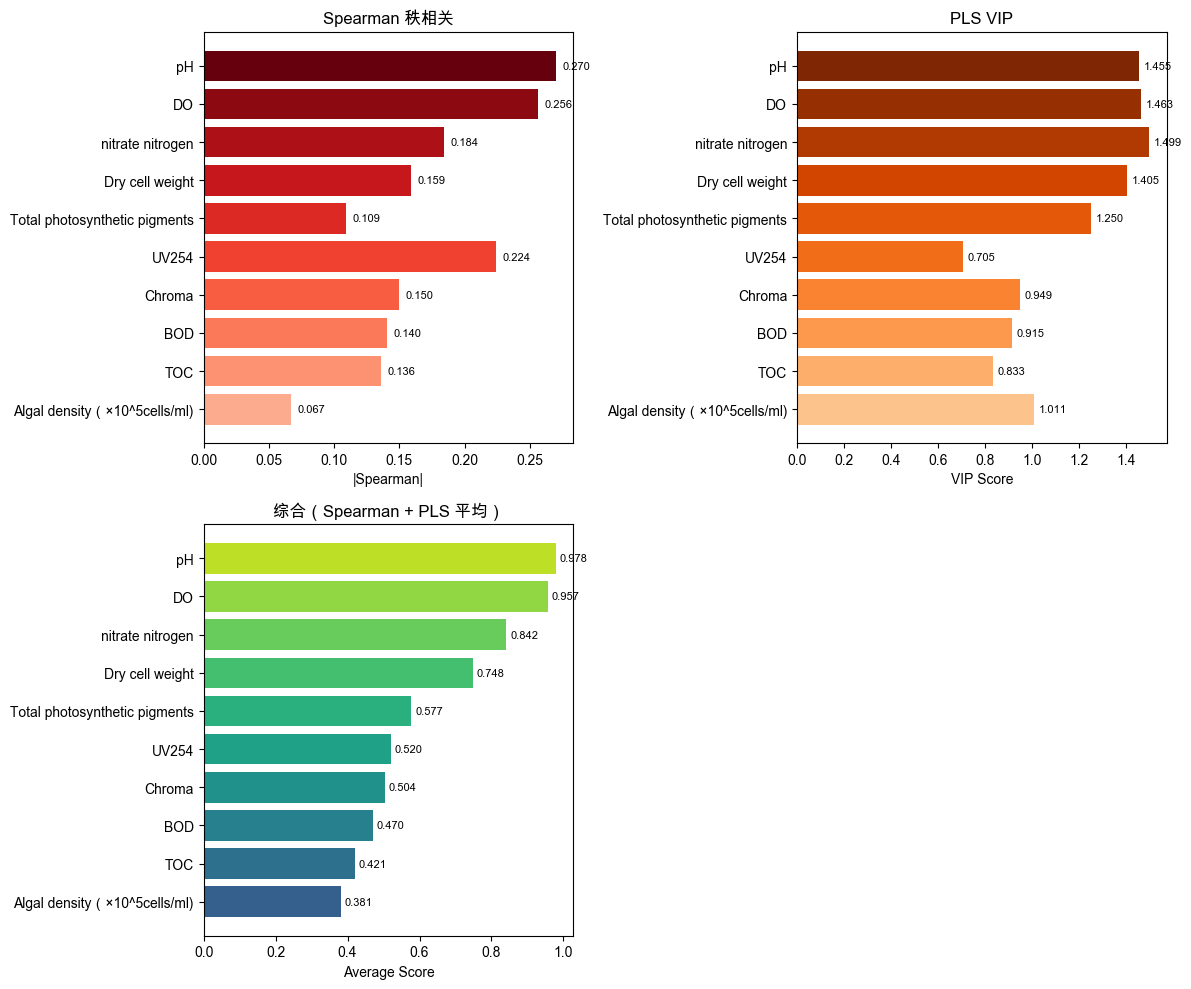

图表保存至: ../results/feature_selection_comparison.png


In [19]:
top_n = 10
top_features = summary_df.head(top_n)['feature'].tolist()
plot_df = summary_df[summary_df['feature'].isin(top_features)].copy().set_index('feature')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Spearman
ax = axes[0]
vals = plot_df.loc[top_features, 'Spearman_Raw'].values
ax.barh(top_features, vals, color=plt.cm.Reds(np.linspace(0.3, 1, top_n))[::-1])
ax.set_xlabel('|Spearman|')
ax.set_title('Spearman 秩相关')
ax.invert_yaxis()
for i, v in enumerate(vals):
    ax.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=8)

# PLS
ax = axes[1]
vals = plot_df.loc[top_features, 'PLS_Raw'].values
ax.barh(top_features, vals, color=plt.cm.Oranges(np.linspace(0.3, 1, top_n))[::-1])
ax.set_xlabel('VIP Score')
ax.set_title('PLS VIP')
ax.invert_yaxis()
for i, v in enumerate(vals):
    ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=8)

# Average (Spearman + PLS)
ax = axes[2]
vals = plot_df.loc[top_features, 'Average'].values
ax.barh(top_features, vals, color=plt.cm.viridis(np.linspace(0.3, 0.9, top_n))[::-1])
ax.set_xlabel('Average Score')
ax.set_title('综合（Spearman + PLS 平均）')
ax.invert_yaxis()
for i, v in enumerate(vals):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# hide unused subplot
axes[3].axis('off')

plt.tight_layout()
plt.savefig('../results/feature_selection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('图表保存至: ../results/feature_selection_comparison.png')


In [20]:
# 保存结果
summary_df.to_excel('../results/feature_selection_results_augment_log.xlsx', index=False)

print('结果已保存')
print('前 10 特征：')
for i, feat in enumerate(summary_df.head(10)['feature'].tolist(), 1):
    print(f'  {i}. {feat}')

结果已保存
前 10 特征：
  1. pH
  2. DO
  3. nitrate nitrogen
  4. Dry cell weight
  5. Total photosynthetic pigments
  6. UV254
  7. Chroma
  8. BOD
  9. TOC
  10. Algal density（×10^5cells/ml)
